### CNN Classifier for MNIST

In this exercise, we use a CNN model to classify items from the MNIST dataset. We will be implementing this using PyTorch.

First, we import the necessary modules:

In [64]:
import torch
import torchvision
import random

import matplotlib.pyplot as plt
from torch import nn
from torchvision import transforms
from tqdm import tqdm

#### Dataloaders

We create the train and test dataloaders by using `torchvision.datasets` to download the MNIST dataset. Some augmentation is also applied to the dataset through `torchvision.transforms`.

In [65]:
# Define the transformation for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create the dataloaders
batch_size = 64
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False)


We sample 16 random samples from the train dataset

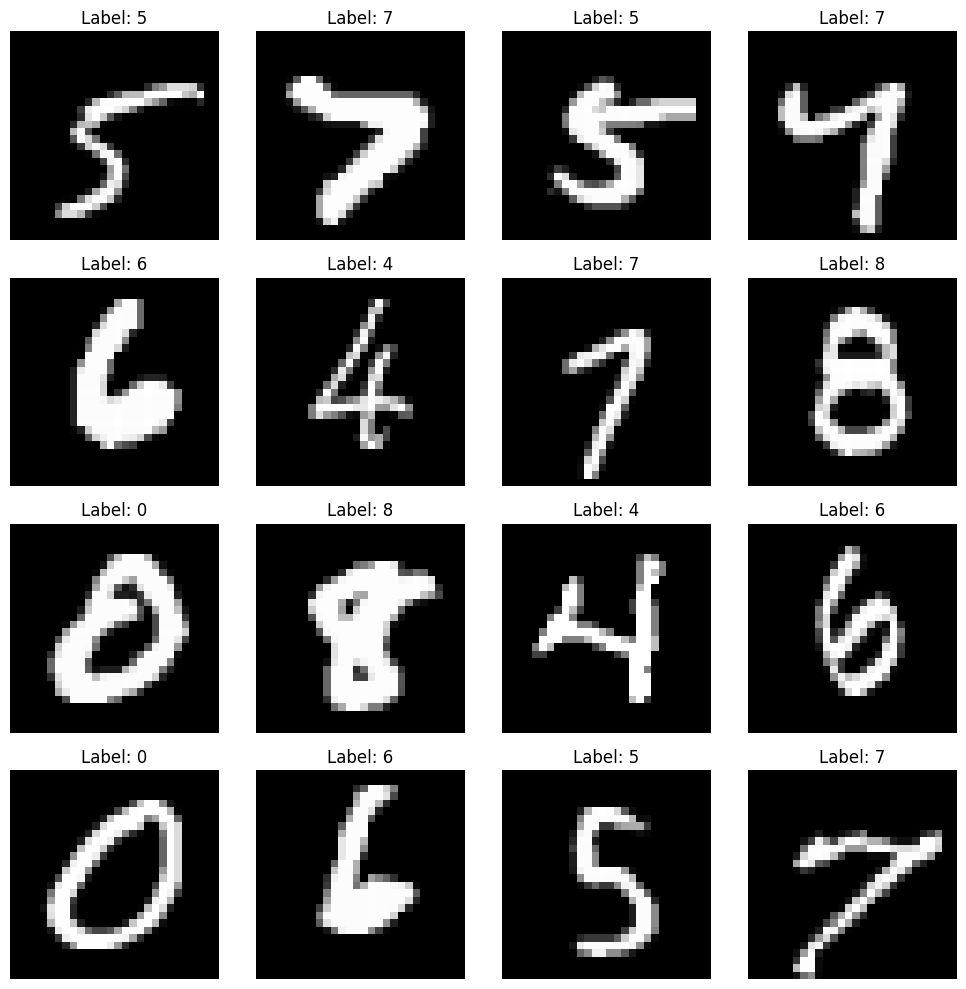

In [66]:
# Get 16 random samples from the train dataset
random_samples = torch.utils.data.random_split(train_dataset, [16, len(train_dataset)-16])[0]

# Plot the images and labels
fig, axs = plt.subplots(4, 4, figsize=(10, 10))

for i, (image, label) in enumerate(random_samples):
    ax = axs[i // 4, i % 4]
    ax.imshow(image.squeeze(), cmap='gray')
    ax.set_title(f"Label: {label}")
    ax.axis('off')

plt.tight_layout()
plt.show()

#### CNN using PyTorch

`nn.Conv2d` is used to create a CNN model. The number of feature maps is increased per layer.

In [67]:
class CNN(nn.Module):
    def __init__(self, in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1, pool_size=2, fc1_size=128, fc2_size=10):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=pool_size, stride=pool_size)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels*2, kernel_size=kernel_size, stride=stride, padding=padding)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=pool_size, stride=pool_size)
        
        self.fc1 = nn.Linear(out_channels*2 * 7 * 7, fc1_size)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(fc1_size, fc2_size)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        
        return x

#### CNN Model, loss function, and optimizer

Here we can define the model as well as its hyperparameters. The `nn.CrossEntropyLoss` loss function was utilized. We use the learning rate and weight decay for the optimizer `torch.optim.Adam`.

In [68]:
# set the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define hyperparameter
lr = 0.001
weight_decay = 0.0001

# Instantiate a CNN model
model = CNN().to(device)

# Declare the loss function
loss_fn = nn.CrossEntropyLoss()

# Declare the optimizer with weight decay
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

#### Training the model

The model is trained for 10 epochs. For each epoch, the average loss is printed. `tqdm` is also used for progress visualization.

In [69]:
# Set the model to training mode
model.train()

# Define the number of epochs
num_epochs = 10

print(f"Running on: {device}")

# Training loop for the model
for epoch in range(num_epochs):
    # Initialize the total loss for the epoch
    total_loss = 0
    
    # Iterate over the batches in the train dataloader
    for images, labels in tqdm(train_dataloader):
        # Move the images and labels to the device
        images = images.to(device)
        labels = labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        
        # Calculate the loss
        loss = loss_fn(outputs, labels)
        
        # Backward pass
        loss.backward()
        
        # Update the weights
        optimizer.step()
        
        # Update the total loss for the epoch
        total_loss += loss.item()

    # Calculate the average loss for the epoch
    avg_loss = total_loss / len(train_dataloader)
    
    # Print the epoch and loss values
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

Running on: cpu


100%|██████████| 938/938 [00:27<00:00, 34.50it/s]


Epoch 1/10, Loss: 0.1537


100%|██████████| 938/938 [00:27<00:00, 34.64it/s]


Epoch 2/10, Loss: 0.0469


100%|██████████| 938/938 [00:27<00:00, 34.50it/s]


Epoch 3/10, Loss: 0.0322


100%|██████████| 938/938 [00:27<00:00, 34.42it/s]


Epoch 4/10, Loss: 0.0250


100%|██████████| 938/938 [00:27<00:00, 34.46it/s]


Epoch 5/10, Loss: 0.0216


100%|██████████| 938/938 [00:27<00:00, 34.70it/s]


Epoch 6/10, Loss: 0.0180


100%|██████████| 938/938 [00:27<00:00, 34.65it/s]


Epoch 7/10, Loss: 0.0161


100%|██████████| 938/938 [00:27<00:00, 34.34it/s]


Epoch 8/10, Loss: 0.0151


100%|██████████| 938/938 [00:27<00:00, 34.63it/s]


Epoch 9/10, Loss: 0.0135


100%|██████████| 938/938 [00:27<00:00, 34.35it/s]

Epoch 10/10, Loss: 0.0112


#### Evaluating the model on the test split

In [70]:
# Set the model to evaluation mode
model.eval()

# Initialize the correct predictions counter
correct_predictions = 0

with torch.no_grad():
# Iterate over the batches in the test dataloader
    for images, labels in test_dataloader:
        # Move the images and labels to the device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        
        # Get the predicted labels
        _, predicted_labels = torch.max(outputs, 1)
        
        # Count the correct predictions
        correct_predictions += (predicted_labels == labels).sum().item()

# Calculate the accuracy
accuracy = correct_predictions / len(test_dataset)

# Print the accuracy
print(f"Accuracy on test split: {accuracy * 100:.2f}%")

Accuracy on test split: 99.13%


#### Sampling 16 random images from the test split

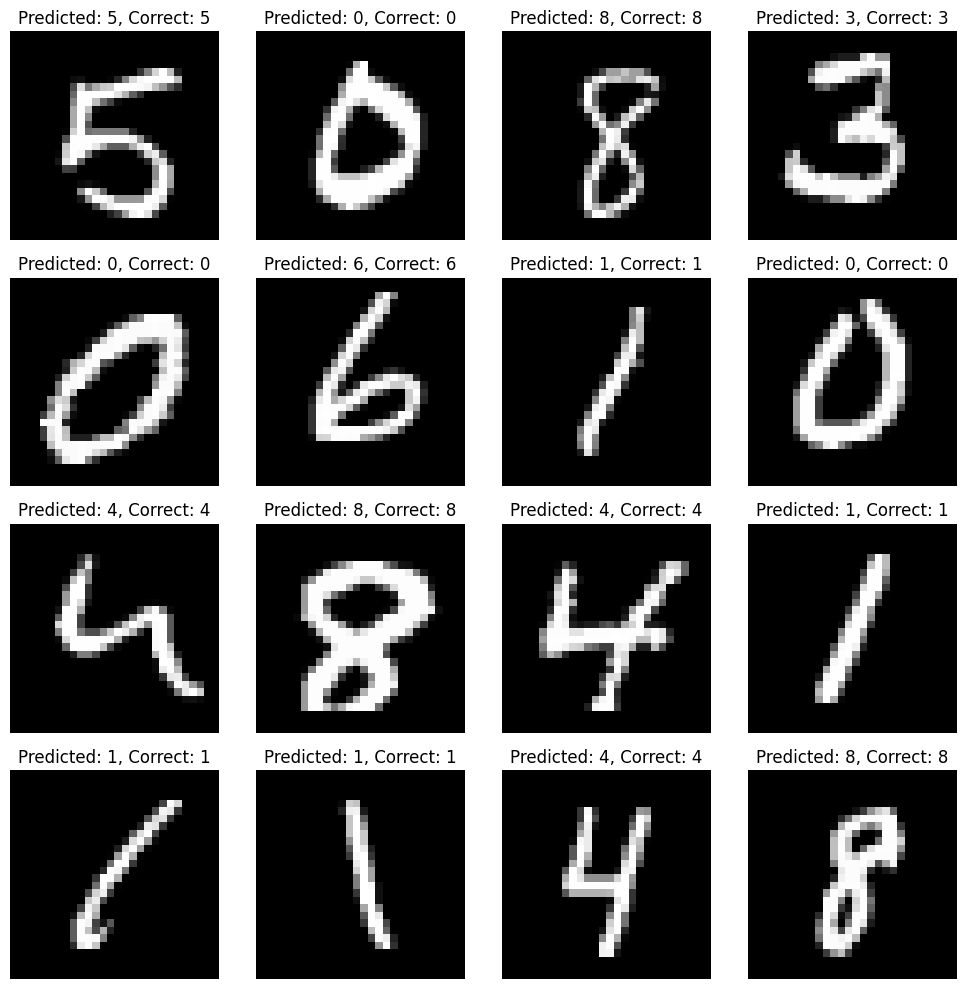

In [71]:
# Get 16 random samples from the test dataset
random_samples = torch.utils.data.random_split(train_dataset, [16, len(train_dataset)-16])[0]

# Create a subplot with 4 rows and 4 columns
fig, axs = plt.subplots(4, 4, figsize=(10, 10))

# Iterate over the random samples
for i, (image, label) in enumerate(random_samples):
    # Move the image to the device
    image = image.unsqueeze(0).to(device)
    
    # Forward pass
    output = model(image)
    
    # Get the predicted label
    _, predicted_label = torch.max(output, 1)
    
    # Get the image data
    image_data = image.squeeze().cpu().numpy()
    
    # Plot the image
    ax = axs[i // 4, i % 4]
    ax.imshow(image_data, cmap='gray')
    ax.set_title(f"Predicted: {predicted_label.item()}, Correct: {label}")
    ax.axis('off')

plt.tight_layout()
plt.show()